In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 128
IMAGE_SIZE = [128, 128]

In [3]:
def get_dataset(dataset_dir):
    """Hàm này lấy dataset từ đường dẫn tệp dataset và lưu dataset dưới dạng Dataframe"""
    filepaths = list(dataset_dir.glob(r'**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    dataset_df = pd.concat([filepaths, labels], axis=1)
    
    dataset_df = dataset_df.sample(frac=1).reset_index(drop = True)
    
    return dataset_df

In [4]:
train_dir = Path('D:/PC/Documents/Tensorflow/Alzheimer Diagnosis CNN Model/Alzheimer Dataset/train')
train_df = get_dataset(train_dir)

train_df.head(3)

,Filepath,Label
0,D:\PC\Documents\Tensorflow\Alzheimer Diagnosis...,No Impairment
1,D:\PC\Documents\Tensorflow\Alzheimer Diagnosis...,Very Mild Impairment
2,D:\PC\Documents\Tensorflow\Alzheimer Diagnosis...,Very Mild Impairment


In [5]:
test_df = Path('D:/PC/Documents/Tensorflow/Alzheimer Diagnosis CNN Model/Alzheimer Dataset (Augmented)/OriginalDataset')
# test_df = Path('D:/PC/Documents/Tensorflow/Alzheimer Diagnosis CNN Model/Alzheimer Dataset/test')
test_df = get_dataset(test_df)

test_df.head(3)

,Filepath,Label
0,D:\PC\Documents\Tensorflow\Alzheimer Diagnosis...,No Impairment
1,D:\PC\Documents\Tensorflow\Alzheimer Diagnosis...,No Impairment
2,D:\PC\Documents\Tensorflow\Alzheimer Diagnosis...,No Impairment


In [6]:
val_df, test_df = train_test_split(test_df, test_size = 0.4, random_state = 55, stratify=test_df["Label"])

In [7]:
image_generator = ImageDataGenerator(rescale = 1.0/255.0)

train_images = image_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

test_images = image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

val_images = image_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

CLASSES = list(test_images.class_indices.keys())

Found 10240 validated image filenames belonging to 4 classes.
Found 2564 validated image filenames belonging to 4 classes.
Found 3846 validated image filenames belonging to 4 classes.


In [8]:
model = Sequential([
    Input(shape=(*IMAGE_SIZE, 3)),

    Conv2D(16, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),

    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax'),
], name = "cnn_custom_model")

model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = tf.losses.CategoricalCrossentropy(),
    metrics = ["accuracy"]
    )

model.summary()

Model: "cnn_custom_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,566,436 (9.79 MB)

 Trainable params: 2,565,444 (9.79 MB)

 Non-trainable params: 992 (3.88 KB)

In [9]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    start_from_epoch=30,
    restore_best_weights=True
)

history = model.fit(train_images, epochs=EPOCHS, validation_data=val_images, validation_freq=1, callbacks=[early_stopping])

C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 69s 195ms/step - accuracy: 0.2990 - loss: 2.0521 - val_accuracy: 0.5013 - val_loss: 1.0441
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 59s 183ms/step - accuracy: 0.6277 - loss: 0.7941 - val_accuracy: 0.5156 - val_loss: 0.9905
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 61s 189ms/step - accuracy: 0.6734 - loss: 0.6570 - val_accuracy: 0.5174 - val_loss: 0.9383
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 63s 197ms/step - accuracy: 0.7184 - loss: 0.5978 - val_accuracy: 0.4782 - val_loss: 1.0899
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 60s 187ms/step - accuracy: 0.7664 - loss: 0.5069 - val_accuracy: 0.4899 - val_loss: 0.9743
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 61s 191ms/step - accuracy: 0.7888 - loss: 0.4550 - val_accuracy: 0.6217 - val_loss: 0.8165
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 62s 194ms/step - accuracy: 0.7969 - loss: 0.4510 - val_accuracy: 0.5065 - val_loss: 2.7199
Epoch 8/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 60s 187ms/step - accuracy: 0.8078 - loss: 0

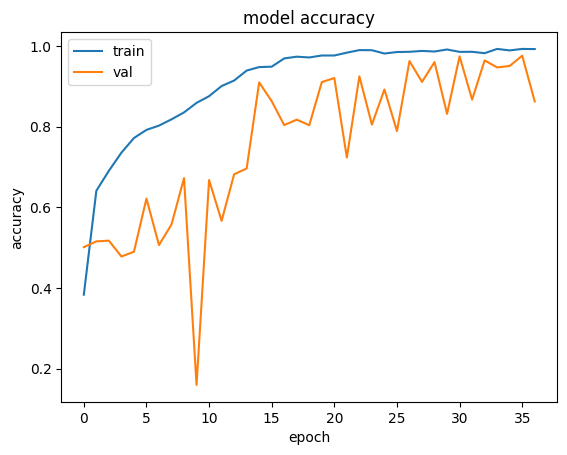

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

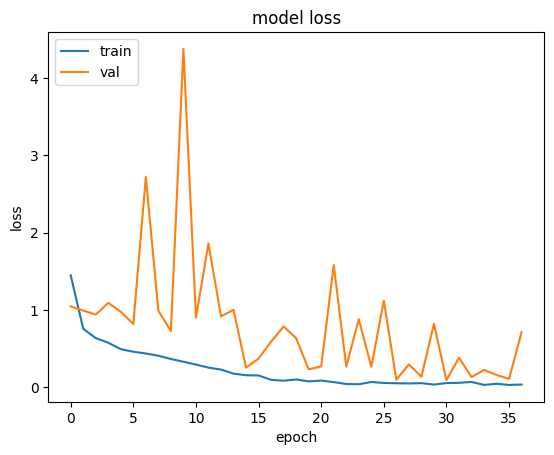

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
test_scores = model.evaluate(test_images)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
pred_labels = model.predict(test_images)

def roundoff(arr):
    """Hàm này chuyển giá trị lớn nhất trong mảng truyền vào = 1, các giá trị còn lại = 0"""
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

pred = np.argmax(pred_labels,axis=1)

print(classification_report(test_images.classes,pred,target_names=CLASSES))

81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.9791 - loss: 0.0669
Testing Accuracy: 97.54%
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step
                      precision    recall  f1-score   support

     Mild Impairment       0.94      1.00      0.97       358
 Moderate Impairment       1.00      1.00      1.00        30
       No Impairment       0.97      0.99      0.98      1280
Very Mild Impairment       0.99      0.94      0.97       896

            accuracy                           0.98      2564
           macro avg       0.98      0.98      0.98      2564
        weighted avg       0.98      0.98      0.98      2564



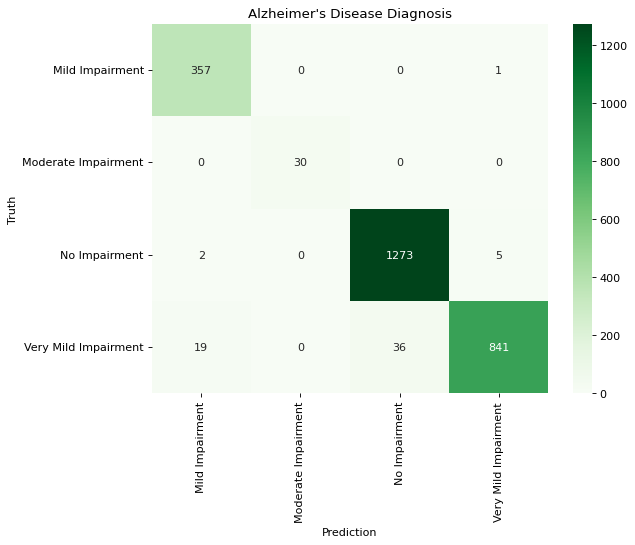

In [13]:
# Plot the confusion matrix to understand the classification in detail
test_ls, pred_ls = test_images.classes,pred
conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [14]:
#Printing some other classification metrics
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 98.26 %
Matthew's Correlation Coefficient: 96.01 %


In [15]:
model.save("Alzheimer_diagnosis_cnn_custom_model_v2(97.54%).h5")